- no augmentation
- 100 epochs (5 max with no improvement)
- train (train_2d_2) + val (val_2d_2) set

this split is the same as fold 4

2025-03-19 15:52:19.457442: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 15:52:19.496245: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 15:52:19.496265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 15:52:19.496285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 15:52:19.503447: I tensorflow/core/platform/cpu_feature_g

Epoch 1/100, Train Loss: 1.1872
Epoch 1/100, Val Loss: 1.1341
Best model saved.
Epoch 2/100, Train Loss: 0.9134
Epoch 2/100, Val Loss: 0.7806
Best model saved.
Epoch 3/100, Train Loss: 0.7332
Epoch 3/100, Val Loss: 0.6092
Best model saved.
Epoch 4/100, Train Loss: 0.5504
Epoch 4/100, Val Loss: 0.4033
Best model saved.
Epoch 5/100, Train Loss: 0.3861
Epoch 5/100, Val Loss: 0.2976
Best model saved.
Epoch 6/100, Train Loss: 0.2837
Epoch 6/100, Val Loss: 0.2110
Best model saved.
Epoch 7/100, Train Loss: 0.2163
Epoch 7/100, Val Loss: 0.1565
Best model saved.
Epoch 8/100, Train Loss: 0.1714
Epoch 8/100, Val Loss: 0.1282
Best model saved.
Epoch 9/100, Train Loss: 0.1395
Epoch 9/100, Val Loss: 0.1060
Best model saved.
Epoch 10/100, Train Loss: 0.1145
Epoch 10/100, Val Loss: 0.0868
Best model saved.
Epoch 11/100, Train Loss: 0.0972
Epoch 11/100, Val Loss: 0.0699
Best model saved.
Epoch 12/100, Train Loss: 0.0826
Epoch 12/100, Val Loss: 0.0718
Epoch 13/100, Train Loss: 0.0715
Epoch 13/100, Val L

/tmp/ipykernel_818384/1009962087.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  processed_preds_tensor = torch.tensor(processed_preds).to(device)
/home/jovyan/.local/lib/python3.10/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/jovyan/.local/lib/python3.10/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


Dice Score: 0.8166
Hausdorff Distance: 10.1506
Pixel Accuracy: 0.9938


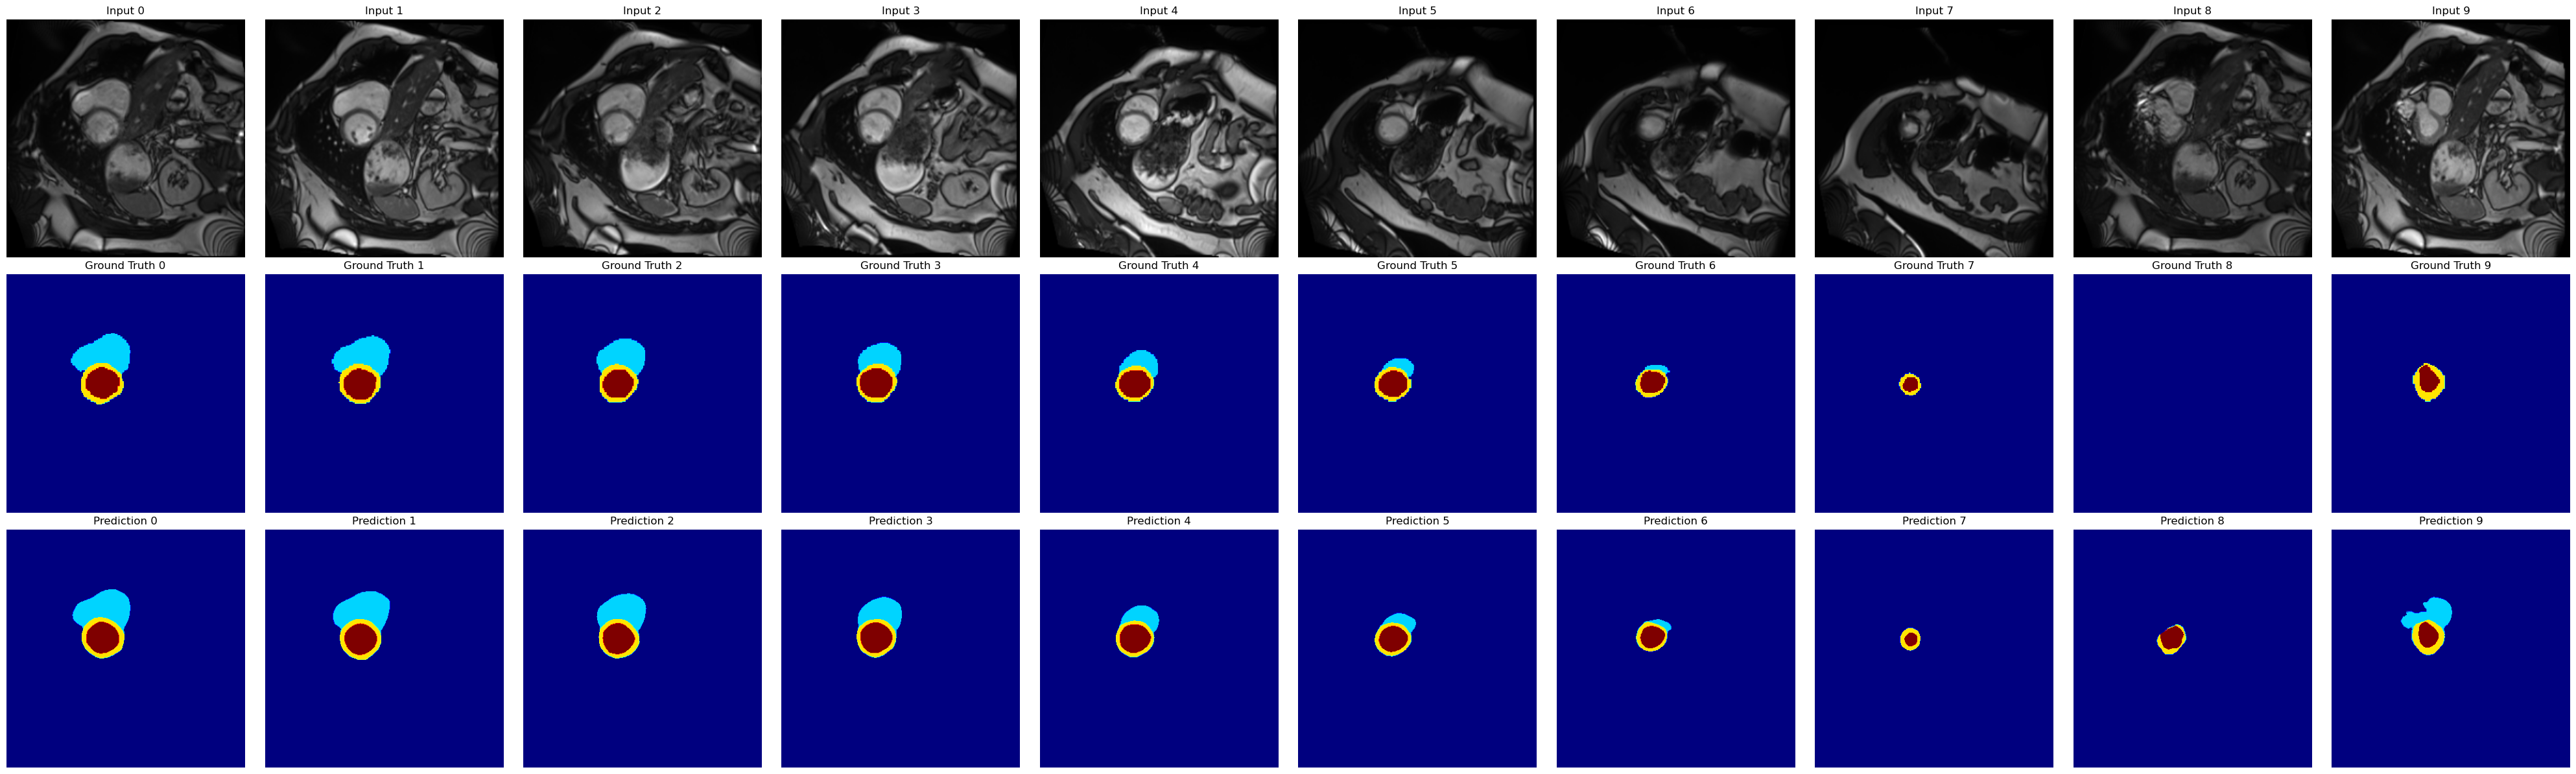

Dice Score,▁
Hausdorff Distance,▁
Pixel Accuracy,▁
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dice Score,0.81663
Hausdorff Distance,10.15061
Pixel Accuracy,0.99376
train_loss,0.01945
val_loss,0.03524


In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.ndimage import label
from monai.networks.nets import UNet
from monai.data import Dataset, DataLoader, pad_list_data_collate
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ToTensord, ResizeD
from monai.metrics import DiceMetric, HausdorffDistanceMetric
import wandb

# Initialize Weights & Biases
wandb.init(project="ACDC", entity="razvan-stanciu98-university-of-twente", name="2DUnet_no_augmentation")

# Define paths
data_dirs = {
    "train": "./dataset/train_2d_2",
    "val": "./dataset/val_2d_2"
}

def load_dataset(data_dir):
    data = []
    for patient in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('.nii') and '_gt' not in file:
                    image_path = os.path.join(patient_path, file)
                    gt_file = file.replace('_slice', '_gt_slice')
                    gt_path = os.path.join(patient_path, gt_file)
                    if os.path.exists(gt_path):
                        data.append({"image": image_path, "label": gt_path})
    return data

datasets = {key: load_dataset(data_dirs[key]) for key in data_dirs}

# Define transforms
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeD(keys=["image", "label"], spatial_size=(352, 352)),
    ToTensord(keys=["image", "label"]),
])

# Create datasets and dataloaders
datasets = {key: Dataset(data=datasets[key], transform=transforms) for key in datasets}
dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=10, shuffle=True, collate_fn=pad_list_data_collate),
    "val": DataLoader(datasets["val"], batch_size=10, shuffle=False, collate_fn=pad_list_data_collate),
}

# Log model architecture
model = UNet(
    spatial_dims=2, in_channels=1, out_channels=4,
    channels=(64, 128, 256, 512, 1024, 2048),
    strides=(2, 2, 2, 2, 2),
    num_res_units=3, norm="batch", dropout=0.2
)

# Log the model architecture to WandB
wandb.watch(model, log="all")  # Log gradients and model parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
class_weights = torch.tensor([0.2, 0.3, 0.3, 0.2], device=device, dtype=torch.float)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

def keep_largest_component(pred_mask, min_size=50):
    output = np.zeros_like(pred_mask)
    for cls in np.unique(pred_mask):
        if cls == 0:
            continue
        binary_mask = (pred_mask == cls).astype(np.int32)
        labeled_array, num_features = label(binary_mask)
        if num_features == 0:
            continue
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0
        largest_label = sizes.argmax()
        if sizes[largest_label] >= min_size:
            largest_component = (labeled_array == largest_label)
            output[largest_component] = cls
    return output

# Training loop
num_epochs = 100
losses = {"train": [], "val": []}
best_val_loss = float('inf')
no_improvement_epochs = 0
patience = 5  # Stop if no improvement after 5 epochs

for epoch in range(num_epochs):
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        with torch.set_grad_enabled(phase == "train"):
            for batch_data in dataloaders[phase]:
                inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device).squeeze(1).long()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloaders[phase])
        losses[phase].append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, {phase.capitalize()} Loss: {epoch_loss:.4f}")

        # Log the loss to WandB
        wandb.log({f"{phase}_loss": epoch_loss})

        if phase == "val":
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), '2DUnet_no_augmentation_train_1903.pth')
                wandb.save('2DUnet_no_augmentation_train_1903.pth')  # Save model to WandB
                print("Best model saved.")
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1
                if no_improvement_epochs >= patience:
                    print("Early stopping triggered.")
                    break
    
    scheduler.step(losses["val"][-1])
    if no_improvement_epochs >= patience:
        break

# Load best model and evaluate
model.load_state_dict(torch.load('2DUnet_no_augmentation_train_1903.pth'))
model.eval()
dice_metric, hd_metric = DiceMetric(include_background=True, reduction="mean"), HausdorffDistanceMetric(include_background=True, percentile=95)

total_correct, total_pixels = 0, 0
with torch.no_grad():
    for val_batch in dataloaders["val"]:
        val_inputs, val_labels = val_batch["image"].to(device), val_batch["label"].to(device)
        val_outputs = model(val_inputs)
        preds_batch = torch.argmax(val_outputs, dim=1, keepdim=True)
        
        # Apply post-processing: Keep the largest connected component
        processed_preds = [keep_largest_component(pred.cpu().numpy(), min_size=50) for pred in preds_batch]
        
        # Convert processed predictions back to tensor for metric calculation
        processed_preds_tensor = torch.tensor(processed_preds).to(device)
        
        # Calculate performance metrics after postprocessing
        dice_metric(y_pred=processed_preds_tensor, y=val_labels)
        hd_metric(y_pred=processed_preds_tensor, y=val_labels)
        
        total_correct += (processed_preds_tensor == val_labels).sum().item()
        total_pixels += torch.numel(val_labels)

dice_score = dice_metric.aggregate().item()
hd_score = hd_metric.aggregate().item()
accuracy = total_correct / total_pixels

# Log metrics to WandB
wandb.log({
    "Dice Score": dice_score,
    "Hausdorff Distance": hd_score,
    "Pixel Accuracy": accuracy
})

print(f"Dice Score: {dice_score:.4f}")
print(f"Hausdorff Distance: {hd_score:.4f}")
print(f"Pixel Accuracy: {accuracy:.4f}")

# Visualize 25 predictions on a validation batch
with torch.no_grad():
    batch = next(iter(dataloaders["val"]))
    inputs = batch["image"].to(device)
    labels = batch["label"].to(device)
    outputs = model(inputs)

    # Get the predicted segmentation as the argmax over the channel dimension
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

    # Apply post-processing: Keep the largest connected component
    processed_preds = [keep_largest_component(pred, min_size=50) for pred in preds]

# Move inputs and labels to CPU for visualization
inputs = inputs.cpu().numpy()   # shape: (B, 1, H, W)
labels = labels.cpu().numpy()   # shape: (B, 1, H, W)

# Number of samples to display (max 25)
num_to_show = min(25, inputs.shape[0])
fig, axs = plt.subplots(3, num_to_show, figsize=(4 * num_to_show, 12))

for i in range(num_to_show):
    # Input image
    axs[0, i].imshow(inputs[i, 0, :, :], cmap="gray")
    axs[0, i].set_title(f"Input {i}")
    axs[0, i].axis("off")

    # Ground truth
    axs[1, i].imshow(labels[i, 0, :, :], cmap="jet")
    axs[1, i].set_title(f"Ground Truth {i}")
    axs[1, i].axis("off")

    # Prediction (after applying keep_largest_component)
    axs[2, i].imshow(processed_preds[i], cmap="jet")
    axs[2, i].set_title(f"Prediction {i}")
    axs[2, i].axis("off")

plt.tight_layout()
plt.show()

# Finish the WandB run
wandb.finish()

- augmentation
- 100 epochs (10 max with no improvement)
- train (train_new) + val (val_2d_2) set

2025-03-19 20:45:57.261273: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 20:45:57.298201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 20:45:57.298222: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 20:45:57.298240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 20:45:57.305443: I tensorflow/core/platform/cpu_feature_g

Training samples: 6104
Validation samples: 376
Epoch 1/100, Train Loss: 0.9967
Epoch 1/100, Val Loss: 0.7227
Best model saved.
Epoch 2/100, Train Loss: 0.4422
Epoch 2/100, Val Loss: 0.2746
Best model saved.
Epoch 3/100, Train Loss: 0.1520
Epoch 3/100, Val Loss: 0.1251
Best model saved.
Epoch 4/100, Train Loss: 0.0799
Epoch 4/100, Val Loss: 0.1018
Best model saved.
Epoch 5/100, Train Loss: 0.0537
Epoch 5/100, Val Loss: 0.1147
Epoch 6/100, Train Loss: 0.0400
Epoch 6/100, Val Loss: 0.1183
Epoch 7/100, Train Loss: 0.0318
Epoch 7/100, Val Loss: 0.1360
Epoch 8/100, Train Loss: 0.0270
Epoch 8/100, Val Loss: 0.1372
Epoch 9/100, Train Loss: 0.0234
Epoch 9/100, Val Loss: 0.1132
Epoch 10/100, Train Loss: 0.0203
Epoch 10/100, Val Loss: 0.1323
Epoch 11/100, Train Loss: 0.0181
Epoch 11/100, Val Loss: 0.1114
Epoch 12/100, Train Loss: 0.0171
Epoch 12/100, Val Loss: 0.1319
Epoch 13/100, Train Loss: 0.0161
Epoch 13/100, Val Loss: 0.1345
Epoch 14/100, Train Loss: 0.0156
Epoch 14/100, Val Loss: 0.1442
Ear

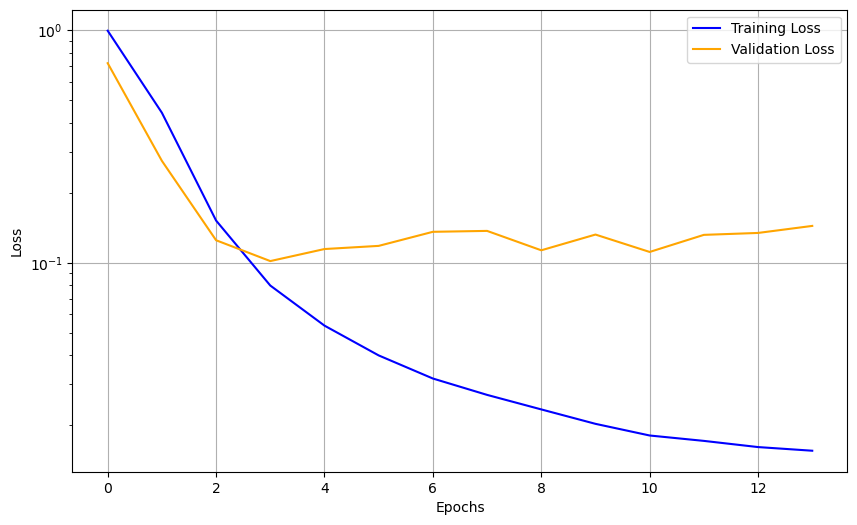

Model loaded successfully.
Validation dataloader ready.


/tmp/ipykernel_819484/3996302208.py:226: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  processed_preds_tensor = torch.tensor(processed_preds).to(device)
/home/jovyan/.local/lib/python3.10/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/jovyan/.local/lib/python3.10/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


Dice Score: 0.2628
Hausdorff Distance: 37.6555
Pixel Accuracy: 0.9821


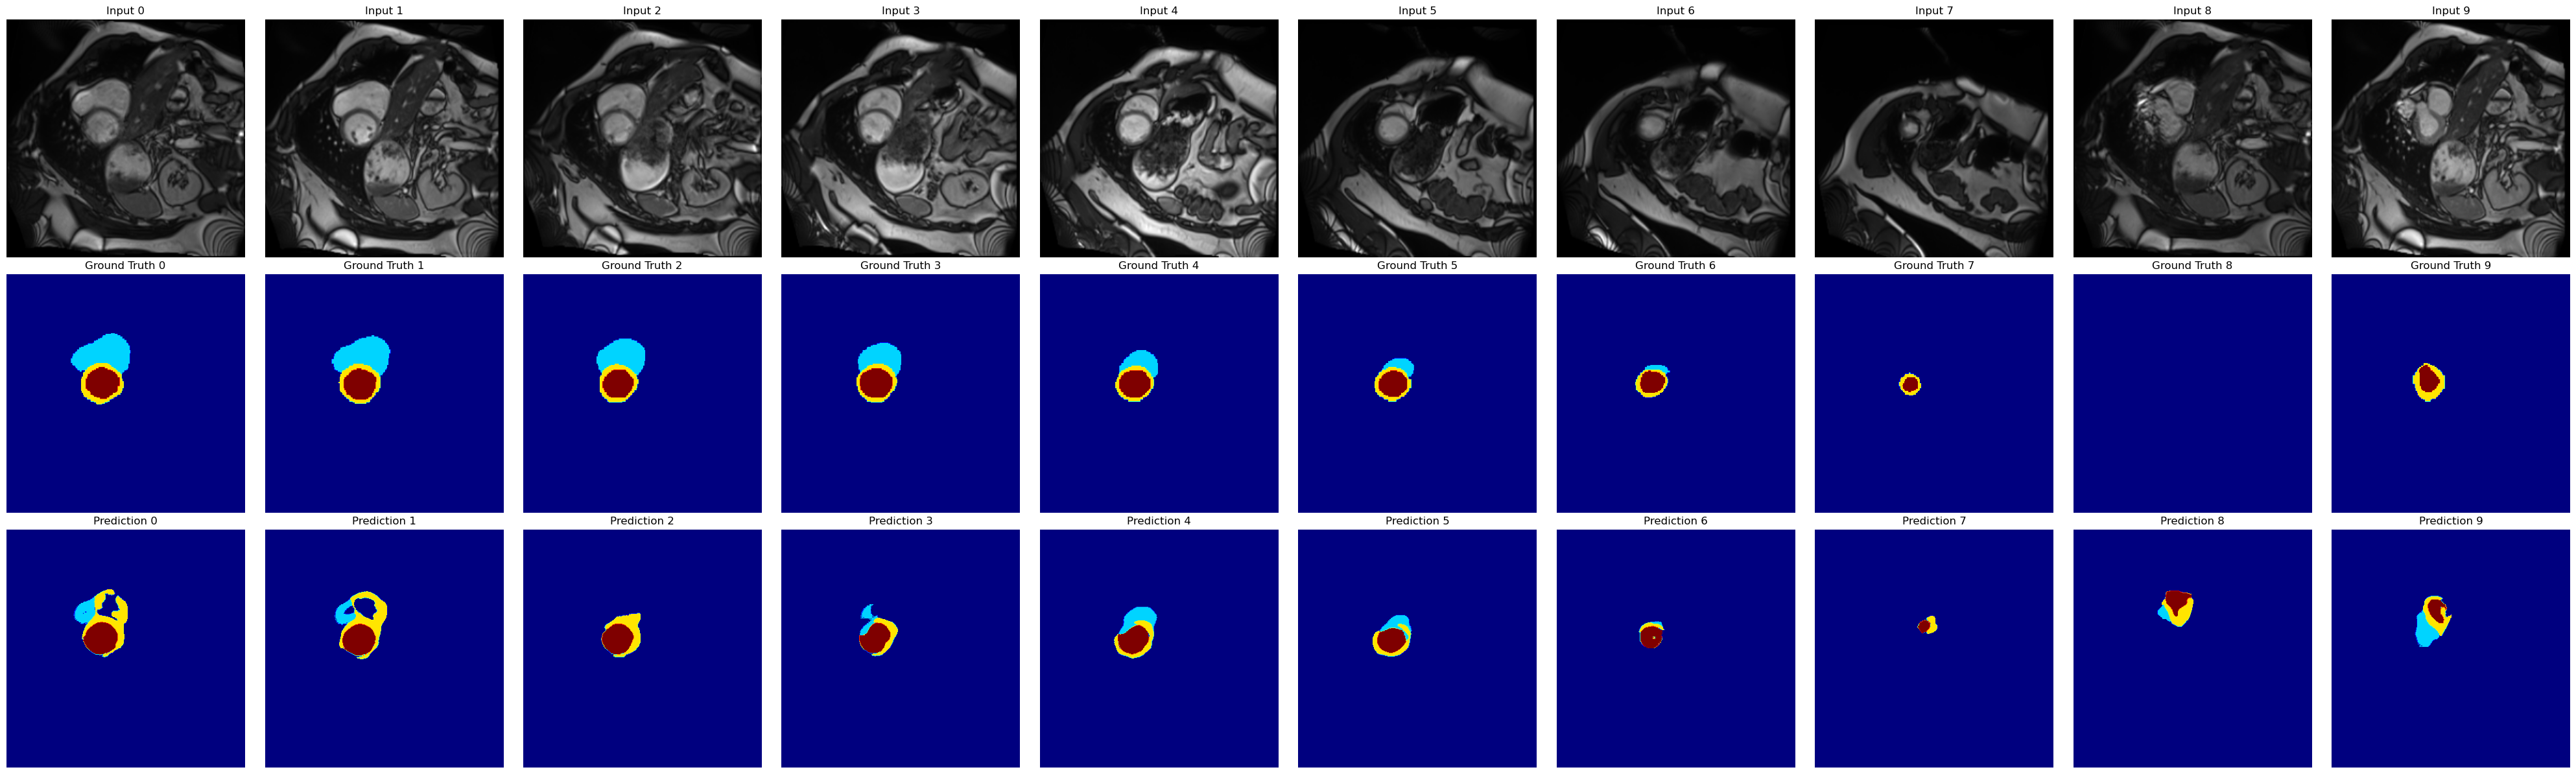

Dice Score,▁
Hausdorff Distance,▁
Pixel Accuracy,▁
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁
Dice Score,0.26283
Hausdorff Distance,37.65548
Pixel Accuracy,0.98206
train_loss,0.01555
val_loss,0.14418


In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.ndimage import label
from monai.networks.nets import UNet
from monai.data import Dataset, DataLoader, pad_list_data_collate
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ToTensord, ResizeD
from monai.metrics import DiceMetric, HausdorffDistanceMetric
import wandb

# Initialize Weights & Biases
wandb.init(project="ACDC", entity="razvan-stanciu98-university-of-twente", name="2DUnet_augmentation")


# Define paths
data_dirs = {
    "train": "./dataset/train_new",
    "val": "./dataset/val_2d_2"
}

def load_train_dataset(data_dir):
    data = []
    for patient in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('.nii') and '_gt' not in file:  # Select all images (original + augmented)
                    image_path = os.path.join(patient_path, file)
                    
                    # Identify corresponding GT file
                    if '_aug' in file:
                        gt_file = file.replace('_aug', '_gt_aug')  # Correct augmented GT filename
                    else:
                        gt_file = file.replace('.nii', '_gt.nii')  # Standard GT file for original images
                    
                    gt_path = os.path.join(patient_path, gt_file)
                    
                    if os.path.exists(gt_path):
                        data.append({"image": image_path, "label": gt_path})
                    else:
                        print(f"Warning: GT not found for {image_path} (Expected: {gt_path})")
    return data

def load_val_dataset(data_dir):
    data = []
    for patient in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('.nii') and '_gt' not in file:
                    image_path = os.path.join(patient_path, file)
                    
                    # Adjust GT naming convention to match observed pattern
                    gt_file = file.replace("slice", "gt_slice")  # Corrects GT filename format
                    gt_path = os.path.join(patient_path, gt_file)

                    if os.path.exists(gt_path):
                        data.append({"image": image_path, "label": gt_path})
                    else:
                        print(f"Warning: GT not found for {image_path} (Expected: {gt_path})")
    return data

datasets = {
    "train": load_train_dataset(data_dirs["train"]),
    "val": load_val_dataset(data_dirs["val"])
}

# Define transforms
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeD(keys=["image", "label"], spatial_size=(352, 352)),
    ToTensord(keys=["image", "label"]),
])

# Create datasets and dataloaders
datasets = {key: Dataset(data=datasets[key], transform=transforms) for key in datasets}
dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=10, shuffle=True, collate_fn=pad_list_data_collate),
    "val": DataLoader(datasets["val"], batch_size=10, shuffle=False, collate_fn=pad_list_data_collate),
}

# Verify dataset sizes
print(f"Training samples: {len(datasets['train'])}")
print(f"Validation samples: {len(datasets['val'])}")

# Define model
in_channels = 1
out_channels = 4
channels = (64, 128, 256, 512, 1024, 2048)
strides = (2, 2, 2, 2, 2)
num_res_units = 3

model = UNet(spatial_dims=2, in_channels=in_channels, out_channels=out_channels,
             channels=channels, strides=strides, num_res_units=num_res_units, norm="batch", dropout=0.2)

# Log the model architecture to WandB
wandb.watch(model, log="all")  # Log gradients and model parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
class_weights = torch.tensor([0.2, 0.3, 0.3, 0.2], device=device, dtype=torch.float)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Post-processing: Keep Largest Connected Component
def keep_largest_component(pred_mask, min_size=50):
    output = np.zeros_like(pred_mask)
    for cls in np.unique(pred_mask):
        if cls == 0:
            continue
        binary_mask = (pred_mask == cls).astype(np.int32)
        labeled_array, num_features = label(binary_mask)
        if num_features == 0:
            continue
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0  # Ignore background
        largest_label = sizes.argmax()
        
        # Keep the largest component if it meets the size requirement
        if sizes[largest_label] >= min_size:
            largest_component = (labeled_array == largest_label)
            output[largest_component] = cls
    return output

# Training loop
num_epochs = 100
losses = {"train": [], "val": []}
best_val_loss = float('inf')
no_improvement_epochs = 0
patience = 10  # Stop if no improvement after 10 epochs

for epoch in range(num_epochs):
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        with torch.set_grad_enabled(phase == "train"):
            for batch_data in dataloaders[phase]:
                inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device).squeeze(1).long()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                else:
                    preds_batch = torch.argmax(outputs, dim=1).cpu().numpy()
                    processed_preds = [keep_largest_component(pred, min_size=50) for pred in preds_batch]
                running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloaders[phase])
        losses[phase].append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, {phase.capitalize()} Loss: {epoch_loss:.4f}")

        # Log the loss to WandB
        wandb.log({f"{phase}_loss": epoch_loss})
        
        if phase == "val":
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), '2DUnet_augmentation_train_1903.pth')
                wandb.save('2DUnet_augmentation_train_1903.pth')  # Save model to WandB
                print("Best model saved.")
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1
                if no_improvement_epochs >= patience:
                    print("Early stopping triggered.")
                    break
    
    scheduler.step(losses["val"][-1])
    if no_improvement_epochs >= patience:
        break

# Plot loss graph
plt.figure(figsize=(10, 6))
plt.plot(losses["train"], label='Training Loss', color='blue')
plt.plot(losses["val"], label='Validation Loss', color='orange')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Load trained weights
try:
    model.load_state_dict(torch.load('2DUnet_augmentation_train_1903.pth'))
    model.eval()
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {str(e)}")

# Check if validation dataloader exists
if "val" not in dataloaders or len(dataloaders["val"]) == 0:
    print("Error: Validation dataloader is empty or undefined.")
else:
    print("Validation dataloader ready.")
    
# Initialize metrics
dice_metric = DiceMetric(include_background=True, reduction="mean")
hd_metric = HausdorffDistanceMetric(include_background=True, percentile=95)

total_correct, total_pixels = 0, 0
with torch.no_grad():
    for val_batch in dataloaders["val"]:
        val_inputs, val_labels = val_batch["image"].to(device), val_batch["label"].to(device)
        val_outputs = model(val_inputs)
        preds_batch = torch.argmax(val_outputs, dim=1, keepdim=True)

        # Apply post-processing: Keep the largest connected component
        processed_preds = [keep_largest_component(pred.cpu().numpy(), min_size=50) for pred in preds_batch]
        
        # Convert processed predictions back to tensor for metric calculation
        processed_preds_tensor = torch.tensor(processed_preds).to(device)

        # Calculate performance metrics after postprocessing
        dice_metric(y_pred=processed_preds_tensor, y=val_labels)
        hd_metric(y_pred=processed_preds_tensor, y=val_labels)

        total_correct += (processed_preds_tensor == val_labels).sum().item()
        total_pixels += torch.numel(val_labels)

# Aggregate metrics
dice_score = dice_metric.aggregate().item()
hd_score = hd_metric.aggregate().item()
accuracy = total_correct / total_pixels

# **Ensure WandB is initialized before logging**
if wandb.run is not None:
    wandb.log({
        "Dice Score": dice_score,
        "Hausdorff Distance": hd_score,
        "Pixel Accuracy": accuracy
    })

print(f"Dice Score: {dice_score:.4f}")
print(f"Hausdorff Distance: {hd_score:.4f}")
print(f"Pixel Accuracy: {accuracy:.4f}")

# Visualize 25 predictions on a validation batch
if "val" in dataloaders and len(dataloaders["val"]) > 0:
    with torch.no_grad():
        batch = next(iter(dataloaders["val"]))
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device)
        outputs = model(inputs)

        # Get the predicted segmentation as the argmax over the channel dimension
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Apply post-processing: Keep the largest connected component
        processed_preds = [keep_largest_component(pred, min_size=50) for pred in preds]

    # Move inputs and labels to CPU for visualization
    inputs = inputs.cpu().numpy()   # shape: (B, 1, H, W)
    labels = labels.cpu().numpy()   # shape: (B, 1, H, W)

    # Number of samples to display (max 25)
    num_to_show = min(25, inputs.shape[0])
    fig, axs = plt.subplots(3, num_to_show, figsize=(4 * num_to_show, 12))

    for i in range(num_to_show):
        axs[0, i].imshow(inputs[i, 0, :, :], cmap="gray")
        axs[0, i].set_title(f"Input {i}")
        axs[0, i].axis("off")

        axs[1, i].imshow(labels[i, 0, :, :], cmap="jet")
        axs[1, i].set_title(f"Ground Truth {i}")
        axs[1, i].axis("off")

        axs[2, i].imshow(processed_preds[i], cmap="jet")
        axs[2, i].set_title(f"Prediction {i}")
        axs[2, i].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No validation samples available for visualization.")

# Finish the WandB run
wandb.finish()

[1,0; 1,0; 2,0; 1,0]

In [ ]:
# Disclaimer:
# This code has been developed with assistance from ChatGPT to support functionality and error handling.
# The authors take full responsibility for its content, functionality, and any outcomes resulting from its use.